# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [166]:
import pickle
from pandas.io.parsers import read_csv
import sys
import os
import time
import numpy as np
from datetime import datetime
import json
import random
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import matplotlib
%matplotlib inline
matplotlib.use('TkAgg', warn = False)

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

X_train_original = X_train
y_train_original = y_train

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [167]:
### Replace each question mark with the appropriate value.

n_train = len(X_train)
n_test = len(X_test)

image_shape = X_train[0].shape
image_size = image_shape[0]
n_classes = len(train['features'])

sign_classes, class_counts = np.unique(y_train, return_counts = True)

n_classes = len(sign_classes)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Image width & height", image_size)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Image width & height 32
Number of classes = 43


We also want to load a dictionary that will be useful when we need to quickly find the class name given the class id

In [148]:
## Create a dictionary of categories
with open('signnames.csv', mode='r') as f:
    lines = f.readlines()
    lines.pop(0)
    lines = [line.replace("\n", '') for line in lines]
    lines = [line.split(",") for line in lines]
    classes = {int(rows[0]):rows[1] for rows in lines}

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

## Visualization Methods

First we want to create some visualization methods that we will be using throughtout the rest of the notebook. These will help us display images

In [154]:
# Select random images and plot a set of random images
import matplotlib.gridspec as gridspec 

# show random images from the whole set or of a specific class
def plotImages(images, cmap=None):
    fig = plt.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    num = len(images)
    for i in range(num):
        axis = fig.add_subplot(1, num, i + 1, xticks=[], yticks=[])
        if cmap:
            axis.imshow(images[i], cmap=cmap)
        else:
            axis.imshow(images[i])
    plt.show()
    
def randomImage(X,y,class_id=None):
    if class_id != None:
        sclass = np.argwhere(y == class_id)
        index = sclass[random.randint(0, len(sclass)-1)][0]
    else:
        index = random.randint(0, len(y))
    return X[index], y[index], index
    
def randomImages(n, X, y, class_id=None):
    images = []
    labels = []
    indexes = []
    for i in range(n):
        image, label, index = randomImage(X,y,class_id)
        images.append(image)
        labels.append(label)
        indexes.append(index)
    return images, labels, indexes

We want to have some visual representations of each class in order to see the quality of each class

Speed limit (20km/h)


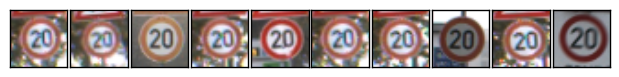

Speed limit (30km/h)


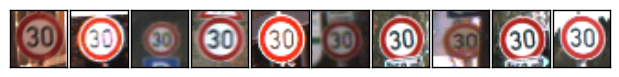

Speed limit (50km/h)


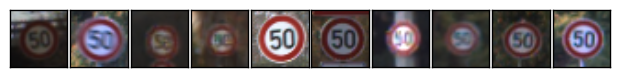

Speed limit (60km/h)


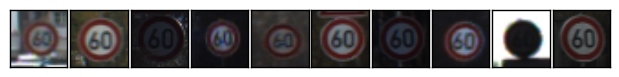

Speed limit (70km/h)


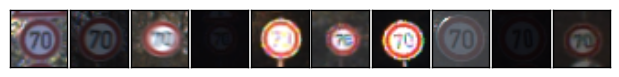

Speed limit (80km/h)


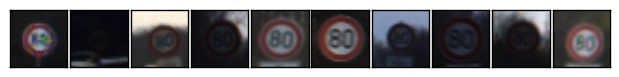

End of speed limit (80km/h)


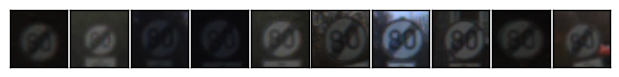

Speed limit (100km/h)


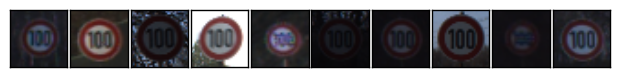

Speed limit (120km/h)


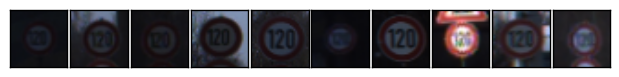

No passing


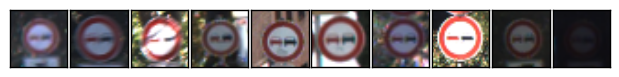

No passing for vehicles over 3.5 metric tons


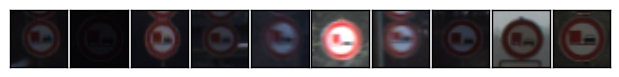

Right-of-way at the next intersection


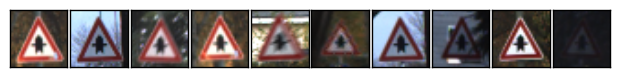

Priority road


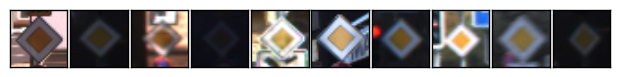

Yield


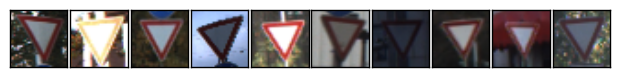

Stop


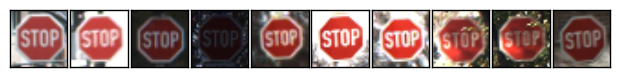

No vehicles


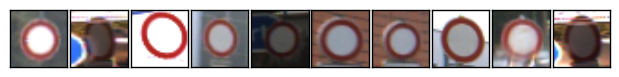

Vehicles over 3.5 metric tons prohibited


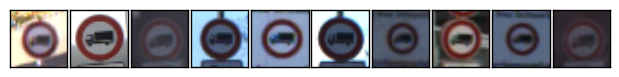

No entry


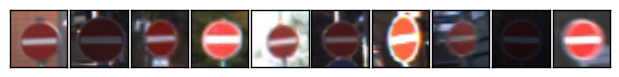

General caution


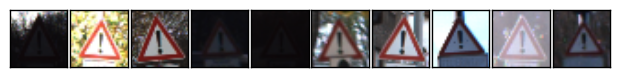

Dangerous curve to the left


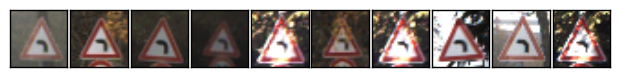

Dangerous curve to the right


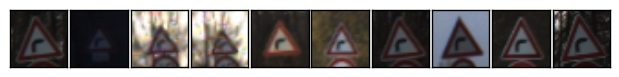

Double curve


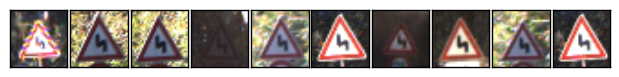

Bumpy road


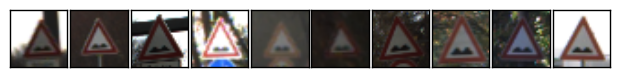

Slippery road


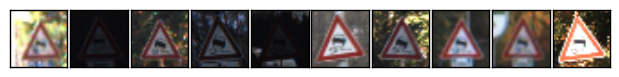

Road narrows on the right


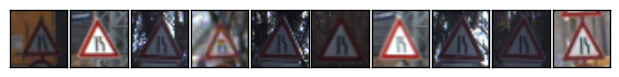

Road work


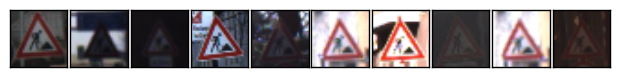

Traffic signals


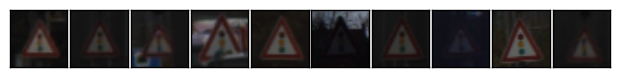

Pedestrians


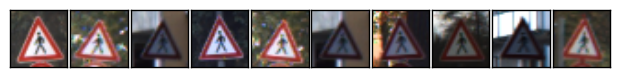

Children crossing


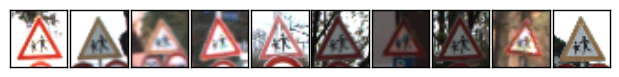

Bicycles crossing


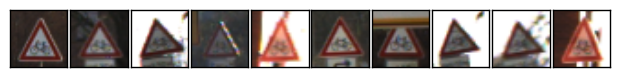

Beware of ice/snow


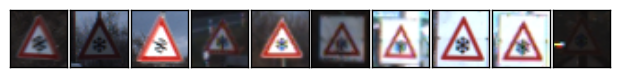

Wild animals crossing


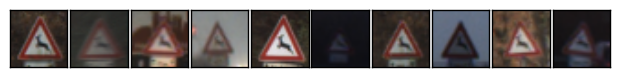

End of all speed and passing limits


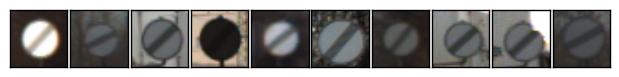

Turn right ahead


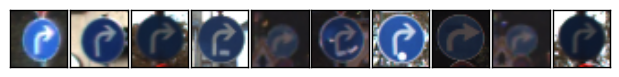

Turn left ahead


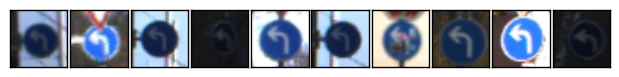

Ahead only


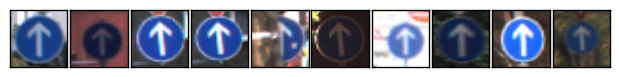

Go straight or right


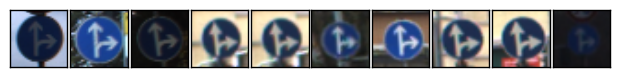

Go straight or left


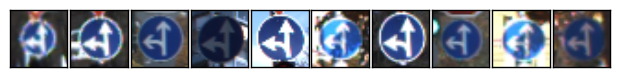

Keep right


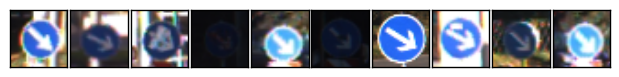

Keep left


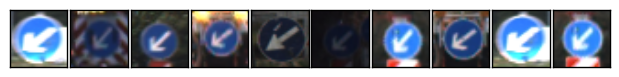

Roundabout mandatory


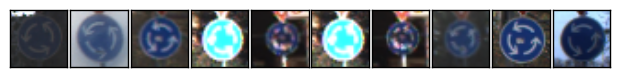

End of no passing


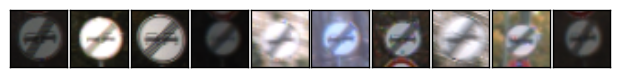

End of no passing by vehicles over 3.5 metric tons


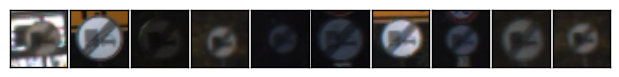

In [155]:
for i in range(n_classes):
    images, labels, indexes = randomImages(10, X_train_original, y_train_original, i)
    print(classes[i])
    plotImages(images)


## Category Representation

In the next few cells we display the frequency of the different classes. We can see that the distribution of class representation is not uniform.

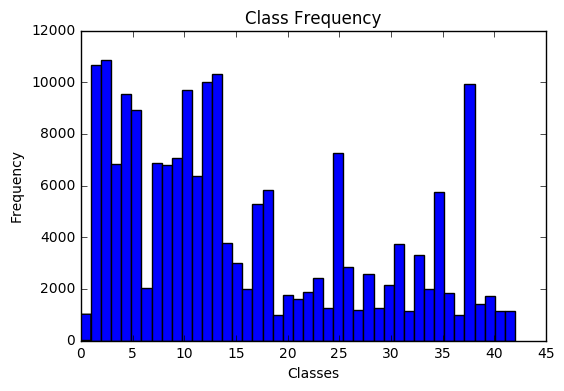

In [156]:
# Display the frequency of the different classes
plt.hist(y_train, bins=43)
plt.title('Class Frequency')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()


In [157]:
# Table of categories sorted by frequency
class_count = {}
total = 0
for label in y_train:
    total += 1
    if label in class_count:
        class_count[label] += 1
    else:
        class_count[label] = 1

import operator
sorted_x = sorted(class_count.items(), key=operator.itemgetter(1))
sorted_x.reverse()
for item in sorted_x:
    print(item[0], item[1], classes[item[0]])
    
print('total: ', total)

2 10857 Speed limit (50km/h)
1 10664 Speed limit (30km/h)
13 10313 Yield
12 10018 Priority road
38 9947 Keep right
10 9691 No passing for vehicles over 3.5 metric tons
4 9539 Speed limit (70km/h)
5 8914 Speed limit (80km/h)
25 7273 Road work
9 7048 No passing
7 6880 Speed limit (100km/h)
3 6834 Speed limit (60km/h)
8 6797 Speed limit (120km/h)
11 6373 Right-of-way at the next intersection
18 5821 General caution
35 5745 Ahead only
17 5294 No entry
14 3768 Stop
31 3742 Wild animals crossing
33 3304 Turn right ahead
15 2985 No vehicles
26 2862 Traffic signals
28 2578 Children crossing
23 2435 Slippery road
30 2159 Beware of ice/snow
6 2030 End of speed limit (80km/h)
34 2009 Turn left ahead
16 1998 Vehicles over 3.5 metric tons prohibited
22 1860 Bumpy road
36 1823 Go straight or right
20 1758 Dangerous curve to the right
40 1707 Roundabout mandatory
21 1618 Double curve
39 1430 Keep left
24 1277 Road narrows on the right
29 1268 Bicycles crossing
27 1168 Pedestrians
32 1155 End of all s

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

## Preprocess Images

I tried 4 different methods of preprocessing images with the goal of making model prediction easier.

- Use histogram equalizing in each channel separetly
- In YUV space equalize only the Y channel (this is what Sermanet et all did)
- Equalize Histogram grayscale
- Use adaptive equalizing in grayscale

In [158]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def equalizeChannels(image):
    img = np.copy(image)
    img[:,:,0] = cv2.equalizeHist(image[:,:,0])
    img[:,:,1] = cv2.equalizeHist(image[:,:,1])
    img[:,:,2] = cv2.equalizeHist(image[:,:,2])
    return img
    
def equalizeImage(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def equalizeGray(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.equalizeHist(img)
    return img

def equalizeAdaptiveGray(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return clahe.apply(img)
    


Equalize Channels


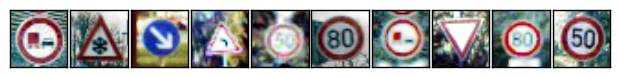

Equalize Y-Channel


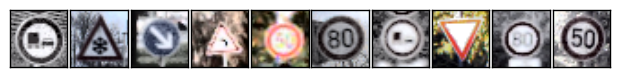

Equalize Grayscale


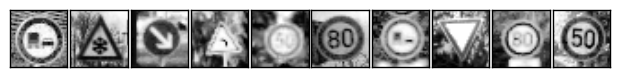

Equalize Adaptive Grayscale


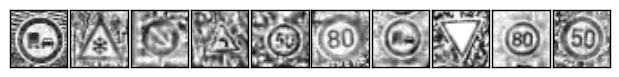

In [160]:
# Visualize what type of preprocessing would be better for the images
images, labels, indexes = randomImages(10, X_train_original, y_train_original)

print("Equalize Channels")
pimages = [equalizeChannels(img) for img in images]
plotImages(pimages)

print("Equalize Y-Channel")
pimages = [equalizeImage(img) for img in images]
plotImages(pimages)

print("Equalize Grayscale")
pimages = [equalizeGray(img) for img in images]
plotImages(pimages, cmap='gray')

print("Equalize Adaptive Grayscale")
pimages = [equalizeAdaptiveGray(img) for img in images]
plotImages(pimages, cmap='gray')

At this stage it is hard to tell with just these images which method would be better. Sermanet et al commented that later they used grayscale images and got better accuracy. This might be because although color is important in road signs, shape is a lot more important. 

I think that simply equalizing each channel separetly won't work as well because each channel is being analyzed independenly. Therefor in color equalizing the Y channel might work better.

Equalizing grayscale looks good, but the method only equalizes according to the overall image. Adaptive equalizing seems to produce more contrast between the important aspects of the image.

I didn't try doing adaptive equalizing on the Y-channel color image to see how that would look. That is one possible thing to explore in the future.

In [168]:
# equalize training data and test data

X_train_pre = np.array([equalizeAdaptiveGray(X_train_original[i]) for i in range(len(X_train_original))])
y_train_pre = y_train_original
X_test = np.array([equalizeAdaptiveGray(X_test[i]) for i in range(len(X_test))])

pickle.dump({"images": X_train_pre, "labels": y_train}, open('train_preprocessed.p','wb'))
pickle.dump({"images": X_test, "labels": y_test}, open('test_preprocessed.p','wb'))

print("Images Processed")

Images Processed


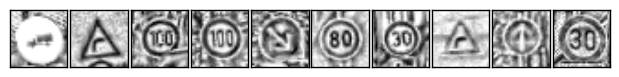

In [169]:
# Display 16 random images from processed data
images, labels, indexes = randomImages(10, X_train_pre, y_train)
plotImages(images, cmap='gray')

Sermanet et al computed the average image and std across all images. I performed this operation using the training set. I also plotted the resulting "average image" as well as the std image. We can see by looking at the average image that the classes with the most representation are clearly affecting the average image.

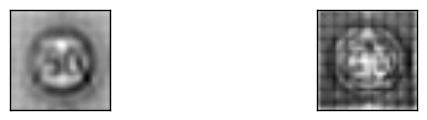

max mean:  205.070443011 min mean: 134.032747583
max std:  63.9935181142 min std: 44.268971318
overall mean: 82.665052346 Overall std:  69.0401785031


In [170]:
# Normalization - calculate the mean and stddev
mean = np.mean(X_train_pre, axis=0)
std = np.std(X_train_pre, axis=0)

pickle.dump({"mean" : mean, "std": std}, open("normalization.p", "wb"))
mean = mean.reshape((32,32))
std = std.reshape((32,32))

# visualize the mean and std
plotImages([mean, std], cmap='gray')

print("max mean: ",np.max(mean), "min mean:", np.min(mean))
print("max std: ",np.max(std), "min std:", np.min(std))
print("overall mean:", np.mean(X_train), "Overall std: ", np.std(X_train))

Train Images: (235254, 32, 32, 1)
Train Labels: (235254,)
Test Images: (12630, 32, 32)
Test Labels: (12630,)
235254
(32, 32)


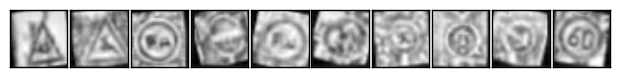

In [27]:
def preprocess(img):
    return (img - mean)/std

X_train_pre = np.array([preprocess(X_aug[i]) for i in range(len(X_aug))])
X_train_pre = X_train_pre.reshape((len(X_train_pre), image_size, image_size, 1))
y_train_pre = y_aug
X_test_pre = np.array([preprocess(X_test[i]) for i in range(len(X_test))])
X_test_pre = X_test.reshape((len(X_test), image_size, image_size, 1))

print('Train Images:', X_train_pre.shape)
print('Train Labels:', y_train_pre.shape)
print('Test Images:', X_test.shape)
print('Test Labels:', y_test.shape)

images, labels, indexes = randomImages(10, X_train_pre, y_train_pre)
images = [img.reshape((image_size, image_size)) for img in images]
print(len(X_train_pre))
print(images[0].shape)
plotImages(images, cmap='gray')

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I chose to preprocess image by performing contract limited adaptive histogram equalization. The idea is that simply equalizing the image is not taking into consideration the localized parts of the image. The CV2 page offers a good explanation of why you prefer to use CLAHE. In our domain we have signs in the foreground and also a background. The background and foreground might have fairly distinct lighting and a dark background might make our sign look washed out.

I also decided to normalize the images so that they would be mean centered and also normalized by the std

## Data Augmentation

Sermanet et al also performed some data augmentation. They jittered each image in the training set and generated 5 additional images. I decided to take the same approach. I performed 3 different types of operations on the images

- Scale the image
- Rotate the image
- Translate the image

The only negative is that my images have a dark border in some cases, for example when scaled down or when translated. One possible thing to do here is to think of a way to not have that border around the image. However, the convolutional neural network should add some robustness.

Other types of augmentation that I could include in the future is shearing, where the top is scaled differently that the bottom of the image. This could be useful if we are driving and see a sign when we are near the bottom of the pole. The perspective in that case would be sign which is shrunk at the top and scaled up at the bottom.

I also only rotated my images between -17 and 17 degrees, like they did in the Sermanet paper. I think in the future I could probably rotate images more.

In [15]:
def scaleImage(image, scale):
    rows,cols = image.shape

    t1 = np.float32([[0,0],[0,5],[5,0]])
    t2 = np.float32([[0,0],[0,5*scale],[5*scale,0]])
    S = cv2.getAffineTransform(t1, t2)
    image = cv2.warpAffine(image,S,(cols,rows))
    
    return image

def rotateImage(image, angle):
    rows,cols = image.shape
    R = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    image = cv2.warpAffine(image,R,(cols,rows))
    return image

def translateImage(image, offsetX, offsetY):
    rows,cols = image.shape
    T = np.float32([[1,0,offsetX],[0,1,offsetY]])
    image = cv2.warpAffine(image,T,(cols,rows))
    return image

def jitterImage(image):
    scale = np.random.uniform(low=0.9, high=1.1)
    angle = np.random.uniform(low=-17,high=17)
    offsetX = np.random.uniform(low=-2, high=2)
    offsetY = np.random.uniform(low=-2, high=2)
    
    image = scaleImage(image, scale)
    image = rotateImage(image, angle)
    image = translateImage(image, offsetX, offsetY)
    return image

Scale Images


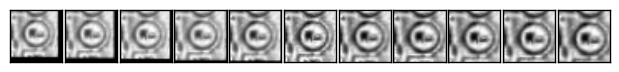

Rotate Images


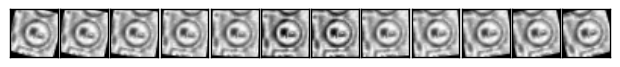

Translate Images


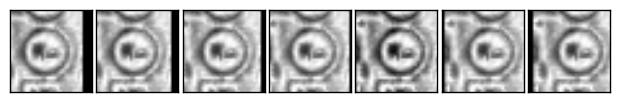

Translate Images


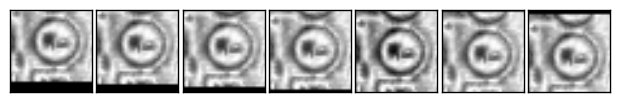

Jitter Image


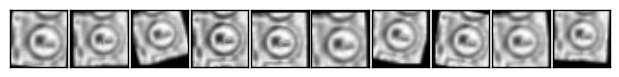

In [16]:
# Visualize how much would be good to scale
image, label, index = randomImage(X_train_pre, y_train_pre)

print("Scale Images")
pimages = [scaleImage(image,i) for i in np.arange(0.9,1.1,0.02)]
plotImages(pimages, cmap='gray')

print("Rotate Images")
pimages = [rotateImage(image, i) for i in np.arange(-17,17,3)]
plotImages(pimages, cmap='gray')

print("Translate Images")
pimages = [translateImage(image, i, 0) for i in range(-4,3,1)]
plotImages(pimages, cmap='gray')

print("Translate Images")
pimages = [translateImage(image, 0, i) for i in range(-4,3,1)]
plotImages(pimages, cmap='gray')

print("Jitter Image")
pimages = [jitterImage(image) for i in range(10)]
plotImages(pimages, cmap='gray')


X_aug size:  (235254, 32, 32)
y_aug size:  (235254,)


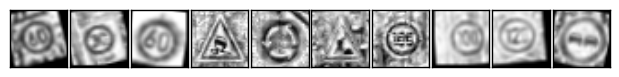

In [17]:
# for each image in the test set generate 5 jittered images to augment our training set
def augmentData(X_train, y_train, examples):
    X = []
    y = []
    for i in range(len(X_train)):
        X.append(X_train[i])
        y.append(y_train[i])
        for j in range(examples):
            img = jitterImage(X_train[i])
            X.append(img)
            y.append(y_train[i])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_aug, y_aug = augmentData(X_train_pre, y_train_pre, 5)

pickle.dump({'X_aug': X_aug, 'y_aug': y_aug}, open('aug_train.p','wb'))

print("X_aug size: ", X_aug.shape)
print("y_aug size: ", y_aug.shape)

images, labels, indexes = randomImages(10, X_aug, y_aug)
plotImages(images, cmap='gray')

In [31]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train, y_train = shuffle(X_train_pre, y_train_pre)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_valid': X_valid,
    'y_valid': y_valid
}

pickle.dump(data, open('data.p','wb'))

print("Training Size: ", len(y_train))
print("Validation Size: ", len(y_valid))

Training Size:  188203
Validation Size:  47051


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I first augmented my dataset by creating 5 jittered images per 1 image in the training set. I shuffled the data and split the set into two sets, the training set with 80% of the images and the validation set with 20% of the images.

This is the standard split between validation and training sets. Generating more data gives our set more opportunities to train on. I decided to include augmented data in the validation set because I want to test how the model would perform on that kind of data.

One possible way we could have augmented the data would have been to create an equal distribution of each class. I felt that the more represented classes are probably more likely to appear in a test set and the neural net learning that bias would be good. This assumption could be wrong and could be easily known if it is false by looking at a database of all the signs in germany. I assume that data is easy to come by, it that case, it would make more sense to augment the data to create equal number of examples for each class

In [32]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

I created a python class that would easily enable to run several experiments to experiment with the different types of architecture and hyperparameters

In [116]:
class Model:
    def __init__(self, name):
        self.name = name
        
    def get_weights(self, shape):
        init = tf.contrib.layers.xavier_initializer()
        return tf.get_variable('weights', shape = shape, initializer = init)

    def get_biases(self, length):
        init = tf.constant_initializer(0)
        return tf.get_variable('bias', shape = [length], initializer = init)

    def conv_layer(self, input, filter_size, num_filters):
        input_size = input.get_shape()[3]
        shape = [filter_size, filter_size, input_size, num_filters]
        W = self.get_weights(shape)
        b = self.get_biases(num_filters)
        layer = tf.nn.conv2d(input, W, strides = [1,1,1,1], padding = 'SAME')
        return tf.nn.relu(layer + b)

    def fc_layer(self, input, output_size):
        input_size = input.get_shape()[1]
        W = self.get_weights([input_size, output_size])
        b = self.get_biases(output_size)
        layer = tf.matmul(input, W) + b
        return layer

    def relu(self, input):
        return tf.nn.relu(input)

    # still working on this methods
    def pool_layer(self, input, size):
        return tf.nn.max_pool(input, ksize=[1, size, size, 1], strides=[1, size, size, 1], padding='SAME')

    def dropout_layer(self, layer, keep):
        return tf.nn.dropout(layer, keep)
    
    def set_architecture(self, config):
        self.epochs = config['epochs']
        self.batch_size = config['batch_size']
        self.learning_rate = config['learning_rate']
        
        # architecture
        self.cv1_k = config['cv1_k']
        self.cv1_f = config['cv1_f']
        self.cv1_p = config['cv1_p']
        
        self.cv2_k = config['cv2_k']
        self.cv2_f = config['cv2_f']
        self.cv2_p = config['cv2_p']
        
        self.cv3_k = config['cv3_k']
        self.cv3_f = config['cv3_f']
        self.cv3_p = config['cv3_p']
        
        self.fc1_s = config['fc1_s'] 
        self.fc1_p = config['fc1_p'] 
        
        if not os.path.exists(self.name):
            os.makedirs(self.name)
            
        self.log_file = open(self.name + '/log.txt','a+')
        
        self.config = config
        
        self.train_accuracy = []
        self.validation_accuracy = []
        self.train_loss = []
        self.validation_loss = []
        
        with open(self.name + '/config.json', 'w') as outfile:
            json.dump(self.config, outfile)

    def create_model(self, config):
        self.set_architecture(config)
        
        # define input
        self.input = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 1], name='input')

        # Convolution Layer 1
        with tf.variable_scope('conv1'):
            conv1 = self.conv_layer(self.input, self.cv1_k, self.cv1_f)
        pool1 = self.pool_layer(conv1, 2)
        self.keep_prob1 = tf.placeholder(tf.float32)
        layer1 = self.dropout_layer(pool1, self.keep_prob1)
        
        # Convolution Layer 2
        with tf.variable_scope('conv2'):
            conv2 = self.conv_layer(layer1, self.cv2_k, self.cv2_f)
        pool2 = self.pool_layer(conv2, 2)
        self.keep_prob2 = tf.placeholder(tf.float32)
        layer2 = self.dropout_layer(pool2, self.keep_prob2)
        
        # Convolution Layer 3
        with tf.variable_scope('conv3'):
            conv3 = self.conv_layer(layer2, self.cv3_k, self.cv3_f)
        pool3 = self.pool_layer(conv3, 2)
        self.keep_prob3 = tf.placeholder(tf.float32)
        layer3 = self.dropout_layer(pool3, self.keep_prob3)

        # 1st stage output
        layer1 = self.pool_layer(layer1, 4)
        shape = layer1.get_shape().as_list()
        layer1 = tf.reshape(layer1, [-1, shape[1] * shape[2] * shape[3]])

        # 2nd stage output
        layer2 = self.pool_layer(layer2, 2)
        shape = layer2.get_shape().as_list()
        layer2 = tf.reshape(layer2, [-1, shape[1] * shape[2] * shape[3]])    

        # 3rd stage output
        shape = layer3.get_shape().as_list()
        layer3 = tf.reshape(layer3, [-1, shape[1] * shape[2] * shape[3]])
        
        flattened = tf.concat(1, [layer1, layer2, layer3])
        
        # define fully connected layers
        with tf.variable_scope('fc1'):
            layer4 = self.relu(self.fc_layer(flattened, self.fc1_s))
        self.keep_prob4 = tf.placeholder(tf.float32)
        layer4 = self.dropout_layer(layer4, self.keep_prob4)

        with tf.variable_scope('fc2'):
            self.logits = self.fc_layer(layer4, n_classes)
            
        # calculate output
        self.target = tf.placeholder(tf.int32, (None), name='target')
        one_hot = tf.one_hot(self.target, n_classes)

        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(self.logits, one_hot)

        # loss operation
        self.loss = tf.reduce_mean(self.cross_entropy)

        # prediction
        prediction_p = tf.nn.softmax(self.logits)
        self.predictions = tf.argmax(prediction_p, 1)

        # accucary operation
        correct_prediction = tf.equal(self.predictions, tf.argmax(one_hot, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # confidence
        self.confidence = tf.nn.top_k(prediction_p)
        
        optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        self.training_operation = optimizer.minimize(self.loss)
        
        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    def confidence(self, image):
        prediction_p = tf.nn.softmax(self.logits)
        top = tf.nn.top_k(prediction_p, k=5)
        
        input = np.array([image])
        dic = { 
            model.input: input,
            self.keep_prob1: 1,
            self.keep_prob2: 1,
            self.keep_prob3: 1,
            self.keep_prob4: 1,
        }
        return self.sess.run(top, feed_dict=dic)
        
    def load(self):
        with open(self.name + '/config.json', 'r') as outfile:
            config = json.load(outfile)
            self.epochs = config['epochs']
            self.batch_size = config['batch_size']
            self.learning_rate = config['learning_rate']

            # architecture
            self.cv1_k = config['cv1_k']
            self.cv1_f = config['cv1_f']
            self.cv1_p = config['cv1_p']

            self.cv2_k = config['cv2_k']
            self.cv2_f = config['cv2_f']
            self.cv2_p = config['cv2_p']

            self.cv3_k = config['cv3_k']
            self.cv3_f = config['cv3_f']
            self.cv3_p = config['cv3_p']

            self.fc1_s = config['fc1_s'] 
            self.fc1_p = config['fc1_p'] 
        
        with open(self.name + '/evaluation.json', 'r') as outfile:
            evaluation = json.load(outfile)
            
        self.train_accuracy = evaluation['train_accuracy']
        self.train_loss = evaluation['train_loss']
        self.validation_accuracy = evaluation['validation_accuracy']
        self.validation_loss = evaluation['validation_loss']

        
    def log(self, *args):
        message = ''
        for m in args:
            message += str(m)
        now = datetime.now()
        self.log_file.write(str(now) + ": " + message+"\n")
        self.log_file.flush()
        print(message)
        
    def plot_accuracy(self):
        l1, = plt.plot(self.train_accuracy, label='Training Set')
        l2, = plt.plot(self.validation_accuracy, label='Validation Set')
        plt.legend(handles=[l1, l2])
        plt.ylabel('Accuracy')
        plt.xlabel('epochs')
        plt.show()
        
    def plot_loss(self):
        l1, = plt.plot(self.train_loss, label='Training Set')
        l2, = plt.plot(self.validation_loss, label='Validation Set')
        plt.legend(handles=[l1, l2])
        plt.ylabel('Loss')
        plt.xlabel('epochs')
        plt.yscale('log')
        plt.show()
        
    def predict(self, image):
        input = np.array([image])
        print('shape: ', input.shape)
        dic = { 
            model.input: input,
            self.keep_prob1: 1,
            self.keep_prob2: 1,
            self.keep_prob3: 1,
            self.keep_prob4: 1,
        }
        predictions = self.sess.run(self.predictions, feed_dict=dic)
        return predictions[0]
        
    
    def evaluate(self, X_data, y_data):
        num_examples = len(X_data)
        total_accuracy = 0
        total_loss = 0
        predictions = []
        cross_entropy = []
        for offset in range(0, num_examples, self.batch_size):
            batch_x, batch_y = X_data[offset:offset + self.batch_size], y_data[offset:offset + self.batch_size]
            dic = {
                model.input: batch_x,
                model.target: batch_y,
                self.keep_prob1: 1,
                self.keep_prob2: 1,
                self.keep_prob3: 1,
                self.keep_prob4: 1
            }
            
            batch_sce, batch_p = self.sess.run([self.cross_entropy, self.predictions], feed_dict=dic)
            
            predictions.extend(batch_p)
            cross_entropy.extend(batch_sce)
        
        predictions = np.array(predictions)
        cross_entroy = np.array(cross_entropy)
        
        accuracy = 100 * np.mean(predictions == y_data)
        loss = np.mean(cross_entropy)
            
        return loss, accuracy
        
    def evaluate_epoch(self, X_train, y_train, X_validation, y_validation):
        tl, ta = self.evaluate(X_train, y_train)
        self.train_accuracy.append(ta.item())
        self.train_loss.append(tl.item())
        
        vl, va = self.evaluate(X_validation, y_validation)
        self.validation_accuracy.append(va.item())
        self.validation_loss.append(vl.item())
        
        evaluation = {
            'train_accuracy': self.train_accuracy,
            'train_loss': self.train_loss,
            'validation_accuracy': self.validation_accuracy,
            'validation_loss': self.validation_loss
        }
        
        with open(self.name + '/evaluation.json', 'w') as outfile:
            json.dump(evaluation, outfile)
        
        
    def train(self, X_train, y_train, X_validation, y_validation):
        
        t0 = time.time()
        num_examples = len(X_train)
        self.log("Training Size: " + str(len(X_train)))
        self.log("Validation Size: " + str(len(X_validation)))
        self.log("")

        for i in range(self.epochs):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, self.batch_size):
                end = offset + self.batch_size
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                dic = {
                    model.input: batch_x,
                    model.target: batch_y,
                    self.keep_prob1: self.cv1_p,
                    self.keep_prob2: self.cv2_p,
                    self.keep_prob3: self.cv3_p,
                    self.keep_prob4: self.fc1_p
                }
                self.sess.run(self.training_operation, feed_dict=dic)

            self.evaluate_epoch(X_train, y_train, X_validation, y_validation)
            self.log("epoch: " + str(i))
            
            # save progress
            saver = tf.train.Saver()
            saver.save(self.sess, self.name + '/model')
            #print_progress(i+1, epochs)

        print("Training: ", self.train_accuracy[-1],' acc ', self.train_loss[-1], ' loss')
        print("Validation: ", self.validation_accuracy[-1],' acc ', self.validation_loss[-1], ' loss')
        self.plot_accuracy()
        self.plot_loss()
        t1 = time.time()
        total = t1-t0
        print("total", total)

In [34]:
def print_tf_variables():
    names = [v.name for v in tf.global_variables()]
    shapes = [v.get_shape().as_list() for v in tf.global_variables()]
    print(len(names), " variables")
    print('Names:', names)
    print('Shapes:', shapes)

(32, 32, 1)
True Label: Dangerous curve to the left
Guess Label: Dangerous curve to the left
Image Shape:  (32, 32, 1)


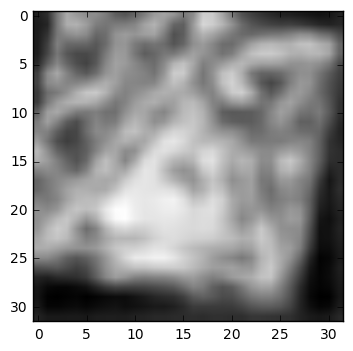

In [62]:
image, label, index = randomImage(X_valid, y_valid)
print(image.shape)
plabel = model.predict(image)
print('True Label:', classes[label])
print('Guess Label:', classes[plabel])
print("Image Shape: ", image.shape)
image = image.reshape((image_size, image_size))
plt.imshow(image, cmap='gray')
plt.show()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My architecture is 3 layers of convolutional neural networks. The output of each layer is fed into a pooling phase and then fed through a drop-out phase. The output of each layer after the dropout is then flattened and pooling is used, then fed into a fully connected network. The paper describes this concept as multiscale features. The idea is that the fully connected network will have available features that the convolution networks detected at each stage and can pick and choose which ones are the more important ones.

After this we had a second fully connected layer that outputs the logits.

In [78]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [ ]:
tf.reset_default_graph()
config = {
    'epochs': 150,
    'learning_rate': 0.00005,
    'batch_size': 256,
    'cv1_k': 5, 'cv1_f': 32, 'cv1_p': 0.9,
    'cv2_k': 5, 'cv2_f': 64, 'cv2_p': 0.8,
    'cv3_k': 5, 'cv3_f': 128, 'cv3_p': 0.7,
    'fc1_s': 1024, 'fc1_p': 0.5,
}
model = Model('slow-learning')
model.create_model(config)
# print_tf_variables()
model.train(X_train, y_train, X_valid, y_valid)

Training Size: 188203
Validation Size: 47051

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52


Learning Rate: 0.001
accu 99.87566550833678 96.91405253761796
loss 0.0047011664137244225 0.1363859474658966


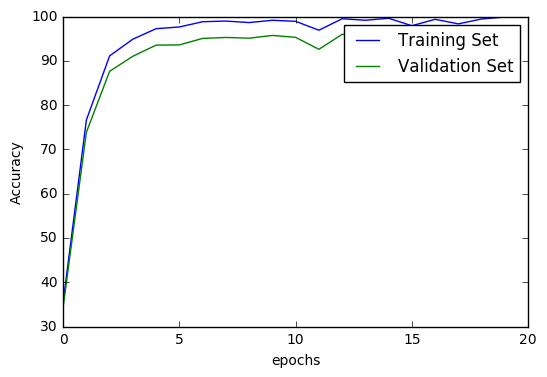

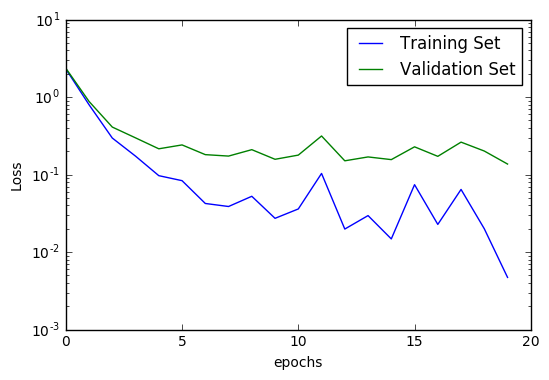

In [173]:
model2 = Model('fast-learning')
model2.load()
print('Learning Rate:', model2.learning_rate)
print('accu', model2.train_accuracy[-1], model2.validation_accuracy[-1])
print('loss', model2.train_loss[-1], model2.validation_loss[-1])
model2.plot_accuracy()
model2.plot_loss()


Learning Rate: 0.001
accu 99.78958778333917 96.6590155572558
loss 0.007920825853943825 0.1490963250398636


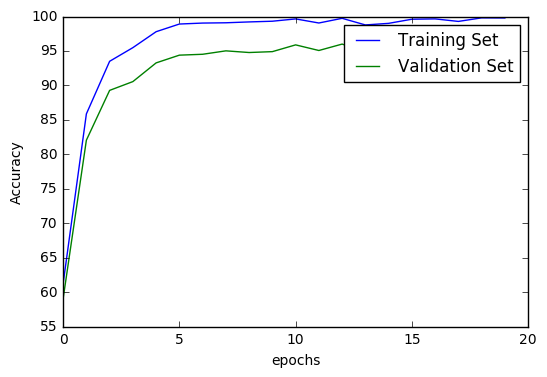

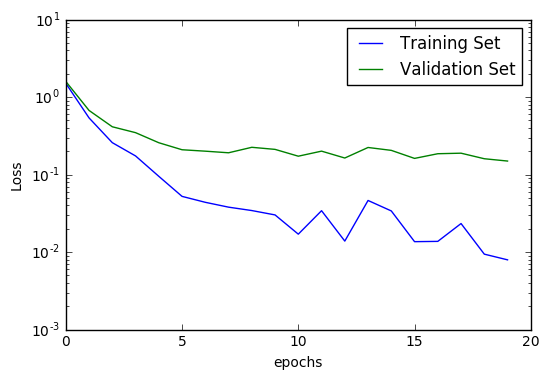

In [174]:
model2 = Model('fast-learning-slow')
model2.load()
print('Learning Rate:', model2.learning_rate)
print('accu', model2.train_accuracy[-1], model2.validation_accuracy[-1])
print('loss', model2.train_loss[-1], model2.validation_loss[-1])
model2.plot_accuracy()
model2.plot_loss()



Learning Rate: 0.0001
accu 88.01287977811076 83.01453710788064
loss 0.4570828676223755 0.8085601329803467


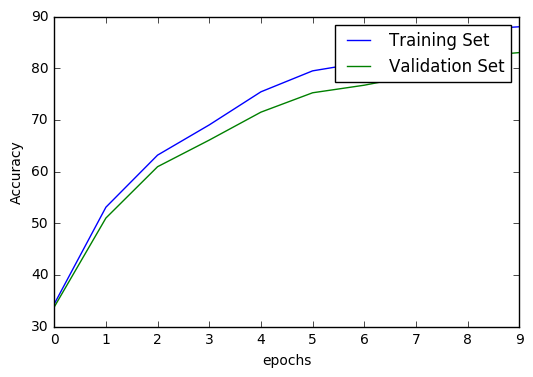

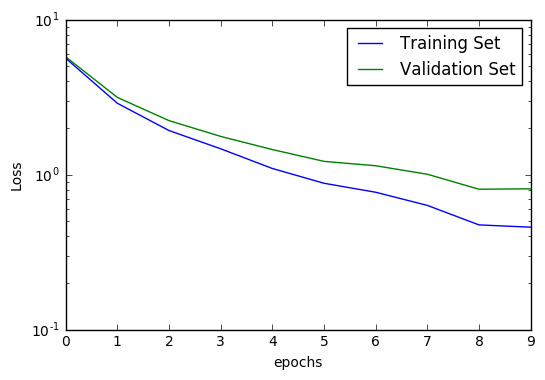

In [175]:
model2 = Model('flat-high')
model2.load()
print('Learning Rate:', model2.learning_rate)
print('accu', model2.train_accuracy[-1], model2.validation_accuracy[-1])
print('loss', model2.train_loss[-1], model2.validation_loss[-1])
model2.plot_accuracy()
model2.plot_loss()


Learning Rate: 0.0001
accu 98.45378901393184 95.16704922213721
loss 0.0757676512002945 0.21084892749786377


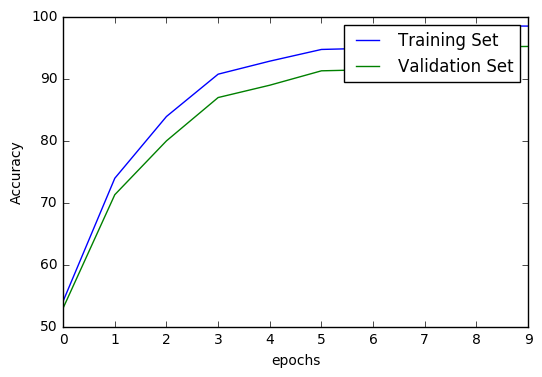

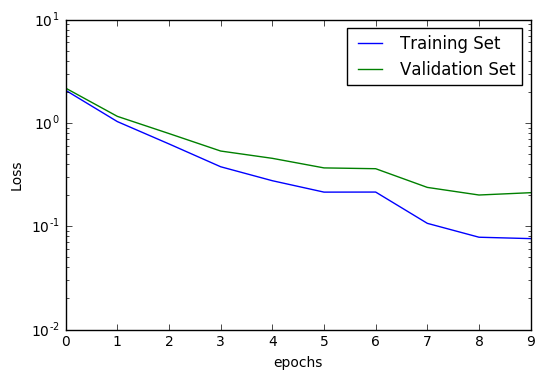

In [176]:
model2 = Model('flat-low')
model2.load()
print('Learning Rate:', model2.learning_rate)
print('accu', model2.train_accuracy[-1], model2.validation_accuracy[-1])
print('loss', model2.train_loss[-1], model2.validation_loss[-1])
model2.plot_accuracy()
model2.plot_loss()

Learning Rate: 0.0001
accu 98.88152686195225 97.68974091942786
loss 0.10904037952423096 0.1395769566297531


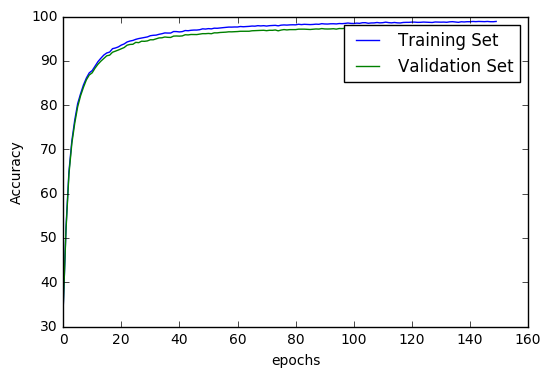

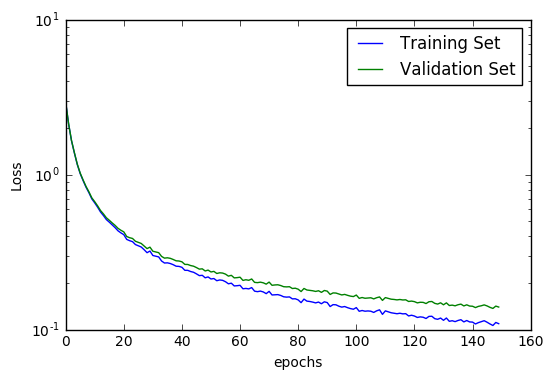

In [177]:
model2 = Model('long-train-6-28-80-p05')
model2.load()
print('Learning Rate:', model2.learning_rate)
print('accu', model2.train_accuracy[-1], model2.validation_accuracy[-1])
print('loss', model2.train_loss[-1], model2.validation_loss[-1])
model2.plot_accuracy()
model2.plot_loss()

Learning Rate: 5e-05
accu 100.0 99.8554759728805
loss 1.787736800906714e-05 0.0050656781531870365


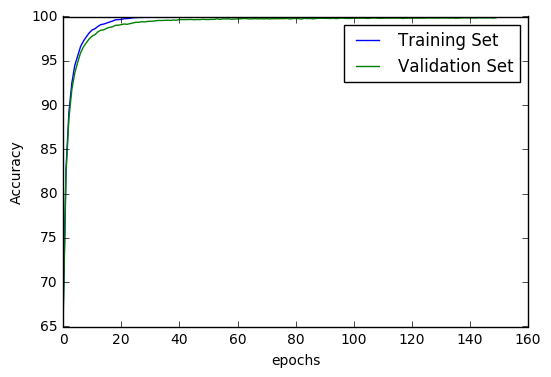

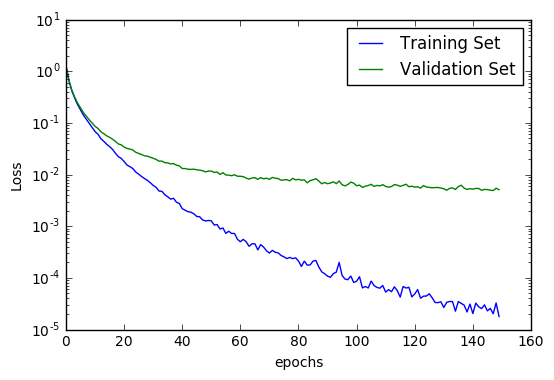

In [178]:
model2 = Model('slow-learning')
model2.load()
print('Learning Rate:', model2.learning_rate)
print('accu', model2.train_accuracy[-1], model2.validation_accuracy[-1])
print('loss', model2.train_loss[-1], model2.validation_loss[-1])
model2.plot_accuracy()
model2.plot_loss()

In [115]:
X_test_pre = np.array([preprocess(img) for img in X_test])
X_testt = X_test_pre.reshape((len(X_test_pre), image_size, image_size, 1))
loss, accuracy = model.evaluate(X_testt, y_test)
print("TEST LOSS: ", loss)
print("TEST ACCURACY: ", accuracy)
print("#Wrong Classifications: ", (100-accuracy)/100.0*len(X_test_pre))

TEST LOSS:  0.15218
TEST ACCURACY:  97.5376088678
#Wrong Classifications:  311.0


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Epochs:

I started by trying out different learning rates at random. I looked at how the loss went down and settled on a learning rate of 0.00005. Faster learning rates made the loss on the training set drop too fast, then it wold just stay at the same level. Slower learning rates would drop the loss too slowly but the accuracy was not any better on the validation set.

I also tried different epochs and noticed that after epoch 80 the loss was not really dropping on the validation set for any of the learning rates I picked.

I then tried different number of nodes at each level. of the network. I only used a batch size of 256. That is something that I could try to vary in the future. The drop-out probabilities were also different at each stage. I settled on 09 at the first layer, 0.8 at the second layer, 0.7 at the third layer and 0.5 in the fully connected layer.

I stopped training when I saw a model reach 100% accuracy in the training set and 99.8% accuracy in the validation set. At this moment I tested my model for the first time on the test set and got an accuracy of 97.5.

I feel like at this point I have overtraining in my model. The loss is not really going down in the validation set after epoch 80.


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

This was my first time doing something like this and it was somewhat overwhealming having so many variables to play with. My approach was to use an architecture and approach that has given good results.



---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

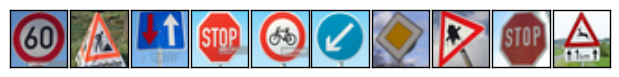

Equalize Grayscale


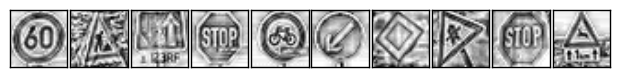

Prediction: Speed limit (60km/h)
Prediction: Road work
Prediction: Keep right
Prediction: Stop
Prediction: Speed limit (60km/h)
Prediction: Keep left
Prediction: Priority road
Prediction: Yield
Prediction: Stop
Prediction: Slippery road


In [95]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg

images = []
for i in range(1,11):
    filename = "%02d" % (i,)
    filename = 'examples/0'+filename+'.png'
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    
# color images
plotImages(images)

# convert to grayscale and 
print("Equalize Grayscale")
pimages = [equalizeAdaptiveGray(img) for img in images]
plotImages(pimages, cmap='gray')

pimages = [preprocess(img) for img in pimages]
pimages = np.array(pimages)

for i in range(10):
    image = pimages[i].reshape((image_size,image_size,1))
    plabel = model.predict(image)
    print('Prediction:', classes[plabel])


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

The Bycicle image should be hard because although the training data has a bicycle sign, it is a triangle and I am testing it on a circle. The third sign in the set of images doesn't appear in out training set. Although the right of way sign appears in our training set, here is highly rotated and there is some shear.

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The accuracy on these images is 60% only 6 out of the 10 images were classified correctly. If we only count the images that were in our dataset we get an accuracy of 80%.

The animal crossing was classified incorrectly, however that sign can be confused with the slippery road sign. The bicycle sign is a circle and the network picked on of the most common circle signs (60 speed limit).

With the two arrows, the network picked an answer that makes sense, keep right, indicating that our network was good a picking rotations.

The eight sign is the one where it messed up the most. It is clearly not a yield, however the image is distorted in such a way that it is difficult to tell if the it is a triangle pointing up or a triangle pointing down.

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

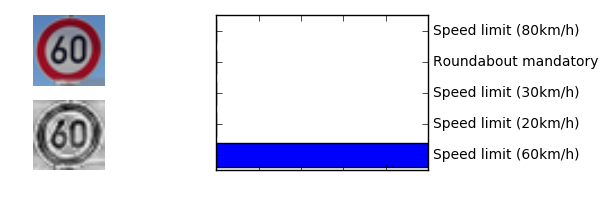

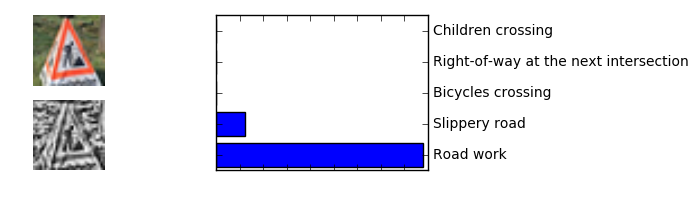

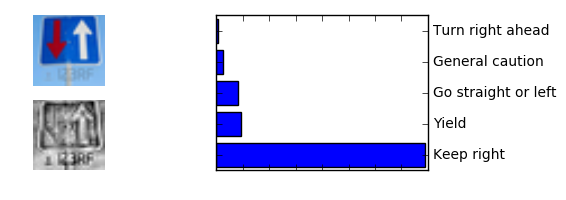

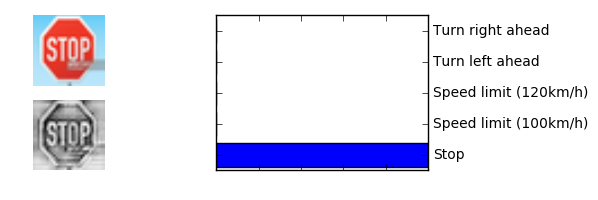

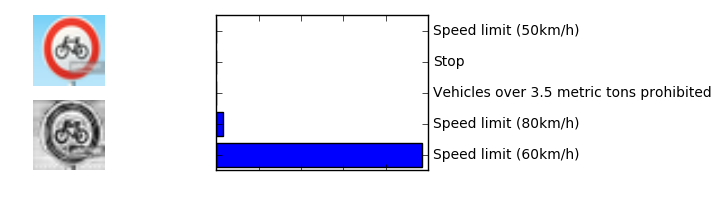

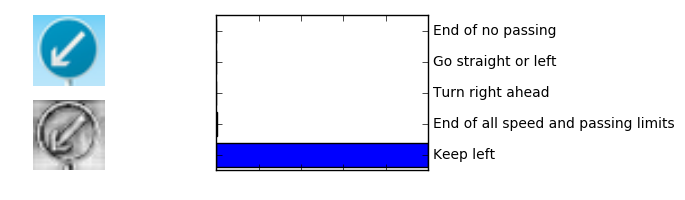

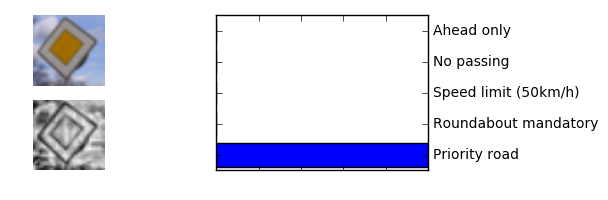

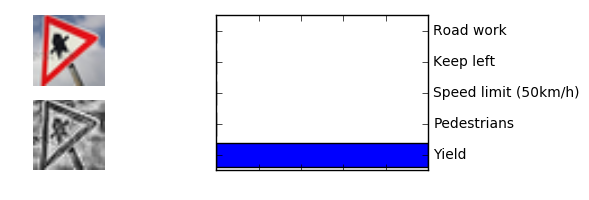

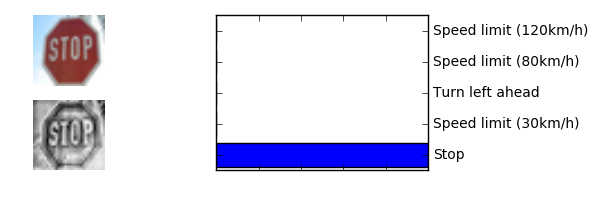

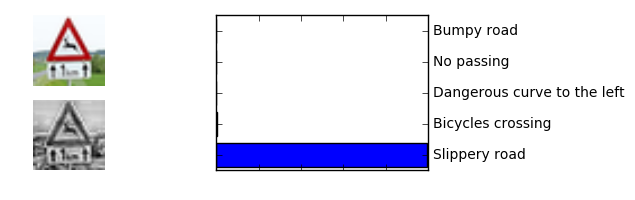

In [145]:
prediction_p = tf.nn.softmax(model.logits)
top = tf.nn.top_k(prediction_p, k=5)
        


    
for i in range(10):
    original = images[i]
    image = pimages[i].reshape((image_size,image_size,1))
    input = np.array([image])
    
    dic = { 
        model.input: input,
        model.keep_prob1: 1,
        model.keep_prob2: 1,
        model.keep_prob3: 1,
        model.keep_prob4: 1,
    }
    top5 = model.sess.run(top, feed_dict=dic)
    predictions = model.sess.run(model.predictions, feed_dict=dic)
    
    # prepare grid
    plt.figure(figsize = (6, 2))
    gridspec.GridSpec(2, 2)
    
    # Plot original image
    plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
    plt.imshow(original)
    plt.axis('off')

    # Plot preprocessed image
    plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
    image = image.reshape((image_size, image_size))
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # Plot predictions
    c = [classes[j] for j in top5.indices[0]]
    plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
    plt.barh(np.arange(5)+.5, top5.values[0], align='center')
    plt.yticks(np.arange(5)+.5, c)
    plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    
    plt.show()
        

**Answer:**

My model appears to be very certain of it's prediction in most of the cases. In the cases where it got the wrong class, the correct answer does not appear in the top 5. I attribute this to possibly overtraining.

I will keep working on this project to learn more about searching parameters.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.